In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from collections import defaultdict

In [2]:
s = 'bacteria'  # Change this to 'bacteria', 'eukaryota', or 'viruses' as needed

count_matrix_path = f'../../dataset/uniprotkb_reference_proteomes/big_{s}_countmatrix.csv'
count_matrix = pd.read_csv(count_matrix_path, index_col=0)
print(f"Original matrix shape: {count_matrix.shape}")
count_matrix = count_matrix[count_matrix.sum(axis=1) > 0]
print(f"Filtered matrix shape (removed zero-sum rows): {count_matrix.shape}")

Original matrix shape: (9098, 14693)
Filtered matrix shape (removed zero-sum rows): (8360, 14693)


In [3]:
new_idx = [idx.split('_')[1] for idx in count_matrix.index]
count_matrix.index = new_idx

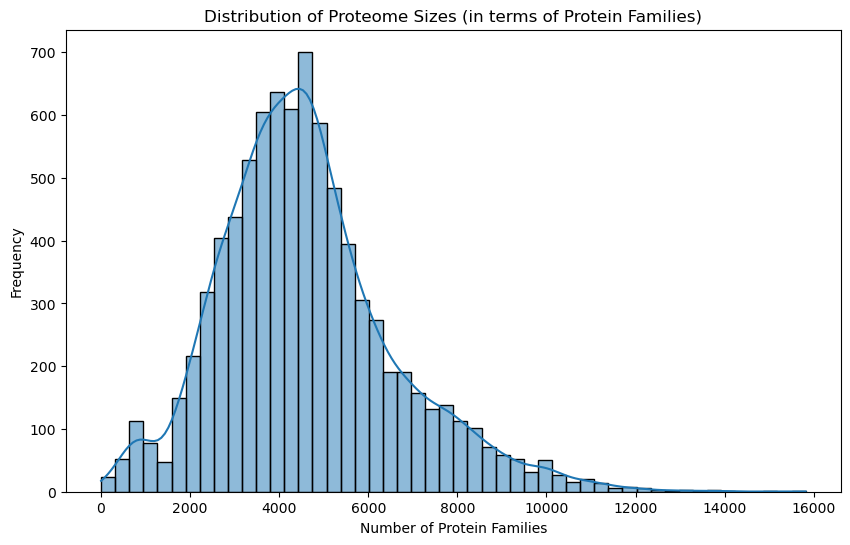

In [4]:
proteome_sizes = count_matrix.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(proteome_sizes, bins=50, kde=True)
plt.title('Distribution of Proteome Sizes (in terms of Protein Families)')
plt.xlabel('Number of Protein Families')
plt.ylabel('Frequency')
plt.show()

In [5]:
thr_size = 1000
filtered_matrix = count_matrix[proteome_sizes >= thr_size]
print(f"Matrix shape after filtering proteomes with size >= {thr_size}: {filtered_matrix.shape}")

Matrix shape after filtering proteomes with size >= 1000: (8157, 14693)


In [6]:
normalized_matrix = filtered_matrix.div(filtered_matrix.sum(axis=1), axis=0)

/mnt/nvme_raid0/tmp/ipykernel_950323/2797640829.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


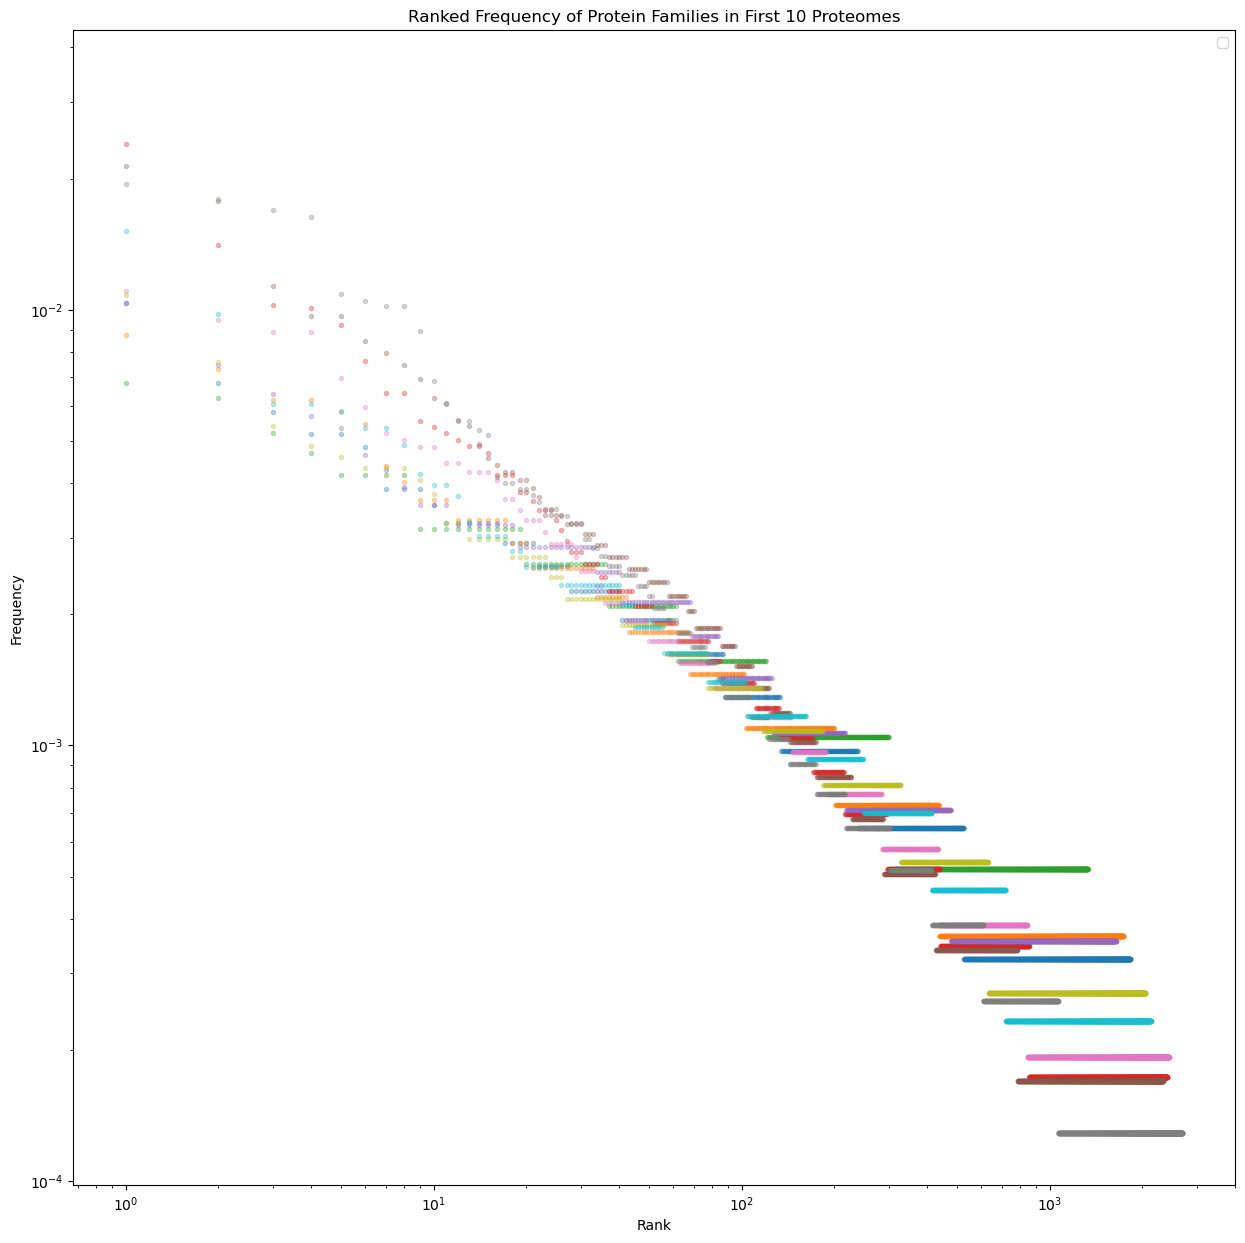

In [7]:
plt.figure(figsize=(15, 15))
for i in range(10):
	j = np.random.randint(0, normalized_matrix.shape[0])
	row = normalized_matrix.iloc[j]
	ranked = np.sort(row[row > 0])[::-1]
	plt.loglog(ranked, marker='o', markersize=3, linestyle='None', alpha=0.3)

# x = np.arange(2, 10000)
# y = 1/x
# k=0.2
# plt.loglog(x, k*y, linestyle='--', color='grey', label='$y=x^{-1}$', linewidth=4)

plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Ranked Frequency of Protein Families in First 10 Proteomes')
plt.legend()
plt.show()

"Groups" may refer to protein families or protein clans

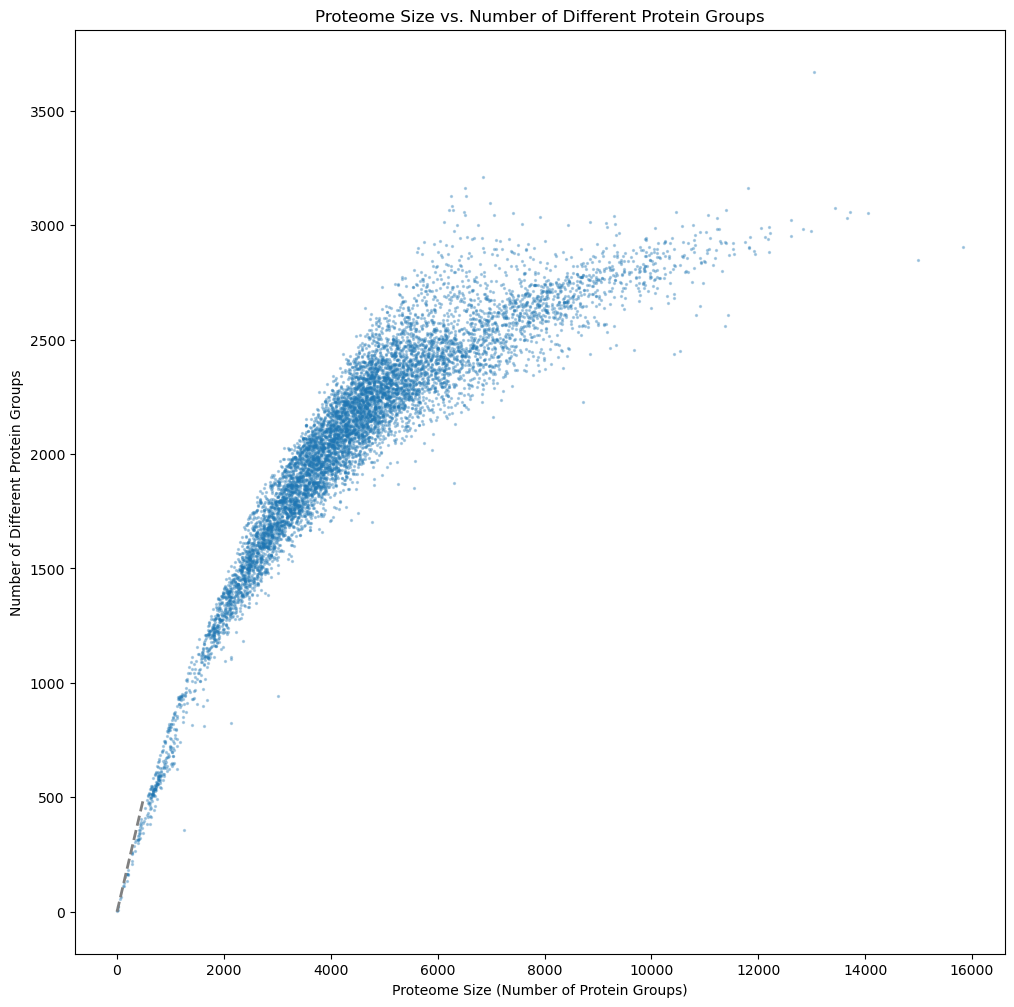

In [8]:
proteome_sizes = count_matrix.sum(axis=1)
n_different_families = (count_matrix > 0).sum(axis=1)
plt.figure(figsize=(12, 12))
x=np.arange(0, 500, 1)
y=x
plt.plot(x, y, linestyle='--', color='grey', label='$y=x$', linewidth=2)
plt.scatter(proteome_sizes, n_different_families, alpha=0.3, s=2)
plt.xlabel('Proteome Size (Number of Protein Groups)')
plt.ylabel('Number of Different Protein Groups')
# plt.xscale('log')
# plt.yscale('log')
plt.title('Proteome Size vs. Number of Different Protein Groups')
plt.show()

______

## NCBI Taxonomy

In [9]:
taxid_to_name_path = '../../dataset/taxonomy_ncbi/taxid_to_name.tsv'
taxid_to_rank_path = '../../dataset/taxonomy_ncbi/taxid_to_rank.tsv'
taxid_to_parent_path = '../../dataset/taxonomy_ncbi/taxid_to_parent.names.ranks.tsv'

tid2nm = {}
with open(taxid_to_name_path, 'r') as f:
	for line in f:
		tid, name = line.strip().split('\t')
		tid2nm[int(tid)] = name
                
nm2tid = {v: k for k, v in tid2nm.items()}

tid2rk = {}
with open(taxid_to_rank_path, 'r') as f:
	for line in f:
		tid, rank = line.strip().split('\t')
		tid2rk[int(tid)] = rank

In [10]:
tree = nx.Graph()
tree_dir = nx.DiGraph()

with open(taxid_to_parent_path, 'r') as f:
    for line in f:
        node_tid, node_rank, node_name, parent_tid, parent_rank, parent_name = line.rstrip('\n').split('\t')

        # normalize ids (keep as strings or cast to int consistently)
        node_tid = int(node_tid)
        parent_tid = int(parent_tid)

        # add nodes with attributes
        tree.add_node(node_tid, name=node_name.strip(), rank=node_rank.strip())
        tree_dir.add_node(node_tid, name=node_name.strip(), rank=node_rank.strip())
        tree.add_node(parent_tid, name=parent_name.strip(), rank=parent_rank.strip())
        tree_dir.add_node(parent_tid, name=parent_name.strip(), rank=parent_rank.strip())

        # parent -> child
        tree.add_edge(parent_tid, node_tid)
        tree_dir.add_edge(parent_tid, node_tid)

tree.remove_edge(1, 1)
tree_dir.remove_edge(1, 1)

print(f'Number of connected components in the tree: {nx.number_connected_components(tree)}')
print(f'Number of weakly connected components in the directed tree: {nx.number_weakly_connected_components(tree_dir)}')

print(f'Number of nodes in the tree: {tree.number_of_nodes()}')
print(f'Number of edges in the tree: {tree.number_of_edges()}')

Number of connected components in the tree: 1
Number of weakly connected components in the directed tree: 1
Number of nodes in the tree: 2703951
Number of edges in the tree: 2703950


__________________

## Colored Heaps' curve

In [36]:
count_matrix.index = count_matrix.index.astype(int)

parent_of = {}
rank_of   = {}
name_of   = {}

for n, data in tree_dir.nodes(data=True):
    rank_of[n] = data.get('rank', '').lower()
    name_of[n] = data.get('name', str(n))

for u, v in tree_dir.edges():
    parent_of[v] = u  # parent -> child edges

def lineage(tid):
    """Yield tid, then its ancestors up to the ultimate root (inclusive)."""
    cur = tid
    seen = set()
    while cur is not None and cur not in seen:
        yield cur
        seen.add(cur)
        cur = parent_of.get(cur, None)

def ancestor_at_rank(tid, target_rank):
    """Return (ancestor_tid, name) at the requested rank; (None, 'Unknown') if not found."""
    target_rank = target_rank.lower()
    for a in lineage(tid):
        if rank_of.get(a, '').lower() == target_rank:
            return a, name_of.get(a, str(a))
    return None, 'Unknown'

def first_child_under_root(tid, root_tid):
    """
    Return the *first node below root_tid* on the path from root -> tid.
    If tid is not under root_tid, return (None, 'Outside root').
    """
    # ascend tid to root, collecting path
    path_up = list(lineage(tid))  # tid -> ... -> root
    if root_tid not in path_up:
        return None, 'Outside root'
    # path_up is bottom-up; find the node whose parent is root_tid
    for node in path_up:
        if parent_of.get(node, None) == root_tid:
            return node, name_of.get(node, str(node))
    # If tid == root_tid, treat it as its own clade
    if tid == root_tid:
        return tid, name_of.get(tid, str(tid))
    return None, 'Outside root'

In [37]:
available_ranks = set(tid2rk.values())
print(f'Available ranks in the taxonomy: {sorted(available_ranks)}')

Available ranks in the taxonomy: ['acellular root', 'biotype', 'cellular root', 'clade', 'class', 'cohort', 'domain', 'family', 'forma', 'forma specialis', 'genotype', 'genus', 'infraclass', 'infraorder', 'isolate', 'kingdom', 'morph', 'no rank', 'order', 'parvorder', 'pathogroup', 'phylum', 'realm', 'section', 'series', 'serogroup', 'serotype', 'species', 'species group', 'species subgroup', 'strain', 'subclass', 'subcohort', 'subfamily', 'subgenus', 'subkingdom', 'suborder', 'subphylum', 'subsection', 'subspecies', 'subtribe', 'subvariety', 'superclass', 'superfamily', 'superorder', 'superphylum', 'tribe', 'varietas']


In [108]:
TARGET_RANK = 'phylum'   # examples: 'superkingdom', 'kingdom', 'phylum', 'class', 'order', ...

# Map each TaxID to the ancestor at that rank
taxids = count_matrix.index.tolist()

clade_id = []
clade_label = []
for tid in taxids:
    a_tid, a_name = ancestor_at_rank(tid, TARGET_RANK)
    clade_id.append(a_tid if a_tid is not None else -1)
    clade_label.append(a_name)

clade_series = pd.Series(clade_label, index=count_matrix.index, name=f'{TARGET_RANK}_clade')
clade_series


1234679                  Bacillota
312153              Pseudomonadota
379731              Pseudomonadota
369723              Actinomycetota
349521              Pseudomonadota
                    ...           
1862145             Pseudomonadota
2864201               Bacteroidota
2795293    Thermodesulfobacteriota
2839743                  Bacillota
472978                   Bacillota
Name: phylum_clade, Length: 8295, dtype: object

In [109]:
# ROOT_TID = 2  # e.g., Bacteria

# clade_id = []
# clade_label = []
# for tid in count_matrix.index:
#     c_tid, c_name = first_child_under_root(tid, ROOT_TID)
#     clade_id.append(c_tid if c_tid is not None else -1)
#     clade_label.append(c_name)

# clade_series = pd.Series(clade_label, index=count_matrix.index, name=f'child_of_{ROOT_TID}')

In [110]:
# remove: "Bacteria incertae sedis", "Outside root", "unclassified Bacteria" and "delta/epsilon subdivisions"
valid_labels = set(clade_series.unique()) - {"Bacteria incertae sedis", "Outside root", "unclassified Bacteria", "delta/epsilon subdivisions"}
clade_series = clade_series[clade_series.isin(valid_labels)]
count_matrix = count_matrix.loc[clade_series.index]
print(f"Matrix shape after filtering by valid clades: {count_matrix.shape}")

Matrix shape after filtering by valid clades: (8295, 14693)


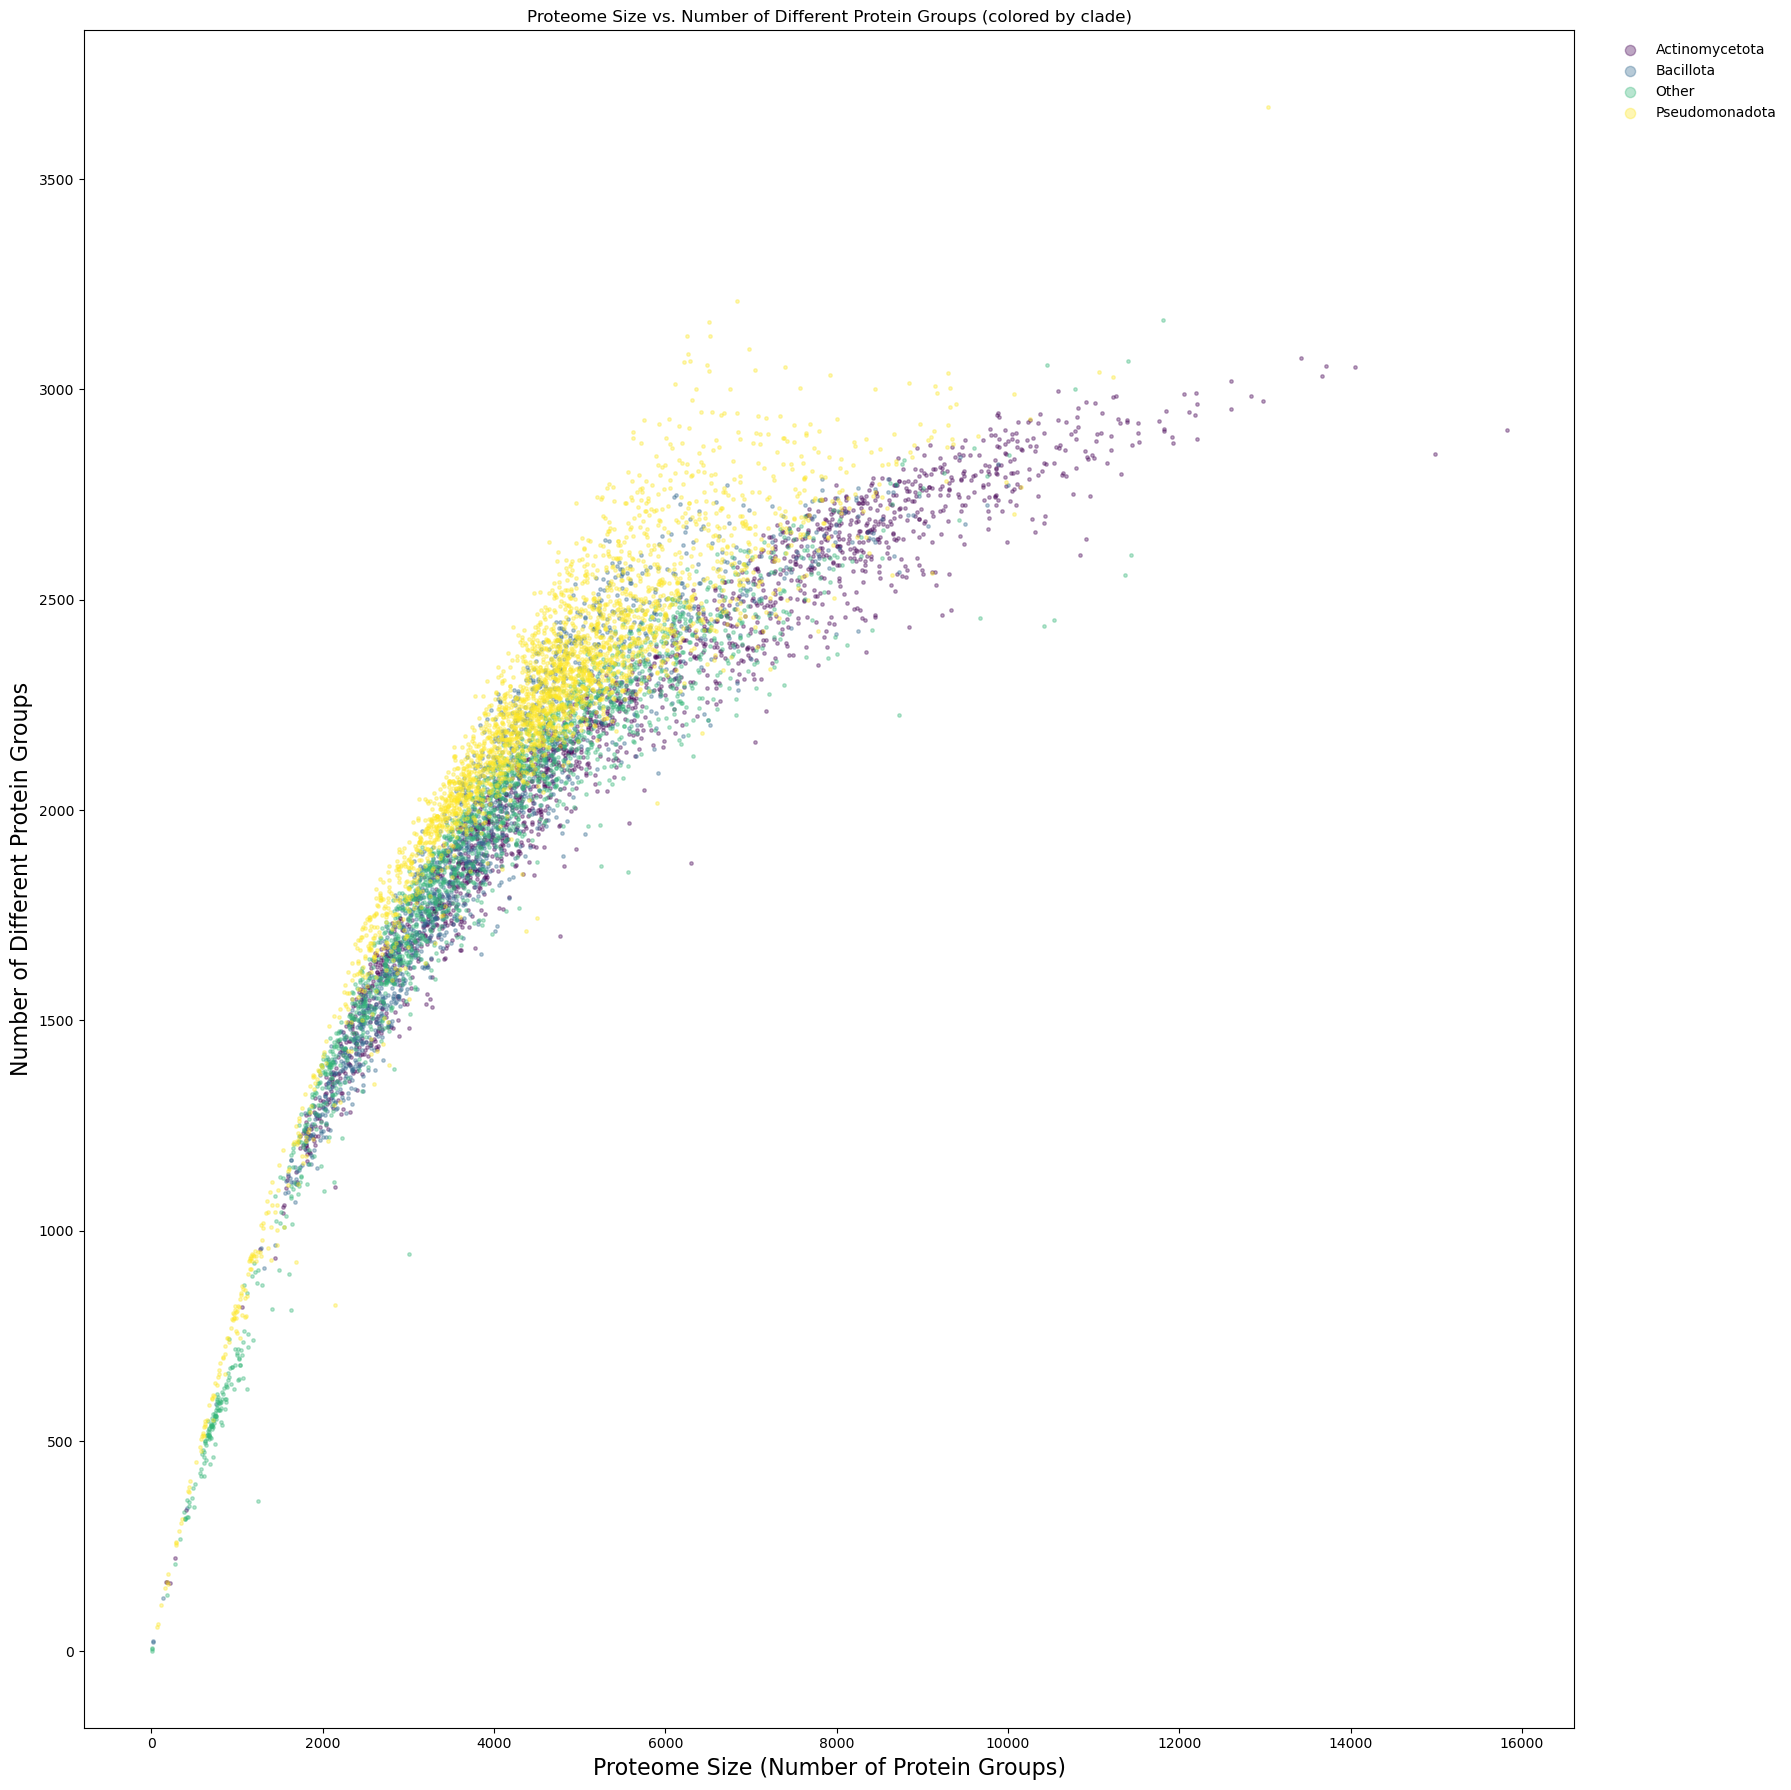

In [111]:
proteome_sizes = count_matrix.sum(axis=1)
n_different_families = (count_matrix > 0).sum(axis=1)

# Put everything in one tidy dataframe
df = pd.DataFrame({
    'size': proteome_sizes,
    'richness': n_different_families,
    'clade': clade_series
}).dropna()

# Optional: show only the top K clades by count, lump the rest as "Other"
K = 3
top_clades = df['clade'].value_counts().head(K).index
df['clade_plot'] = np.where(df['clade'].isin(top_clades), df['clade'], 'Other')

unique_labels = df['clade_plot'].unique().tolist()

if 'Other' in unique_labels:
	unique_labels.remove('Other')
	unique_labels.append('Other')  # ensure "Other" is last for consistent coloring

cmap = plt.get_cmap('viridis', len(unique_labels))
color_map = {lab: cmap(i % cmap.N) for i, lab in enumerate(sorted(unique_labels))}

# Plot
plt.figure(figsize=(18, 18))
#x = np.arange(0, int(df['size'].max()*0.2) + 1, 1)
#plt.plot(x, x, linestyle='--', color='grey', label='$y=x$', linewidth=2)

for lab in sorted(unique_labels):
    sub = df[df['clade_plot'] == lab]
    plt.scatter(sub['size'], sub['richness'], s=6, alpha=0.35, label=lab, c=[color_map[lab]])

plt.xlabel('Proteome Size (Number of Protein Groups)', fontsize=16)
plt.ylabel('Number of Different Protein Groups', fontsize=16)
plt.title('Proteome Size vs. Number of Different Protein Groups (colored by clade)')
plt.legend(markerscale=3, frameon=False, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

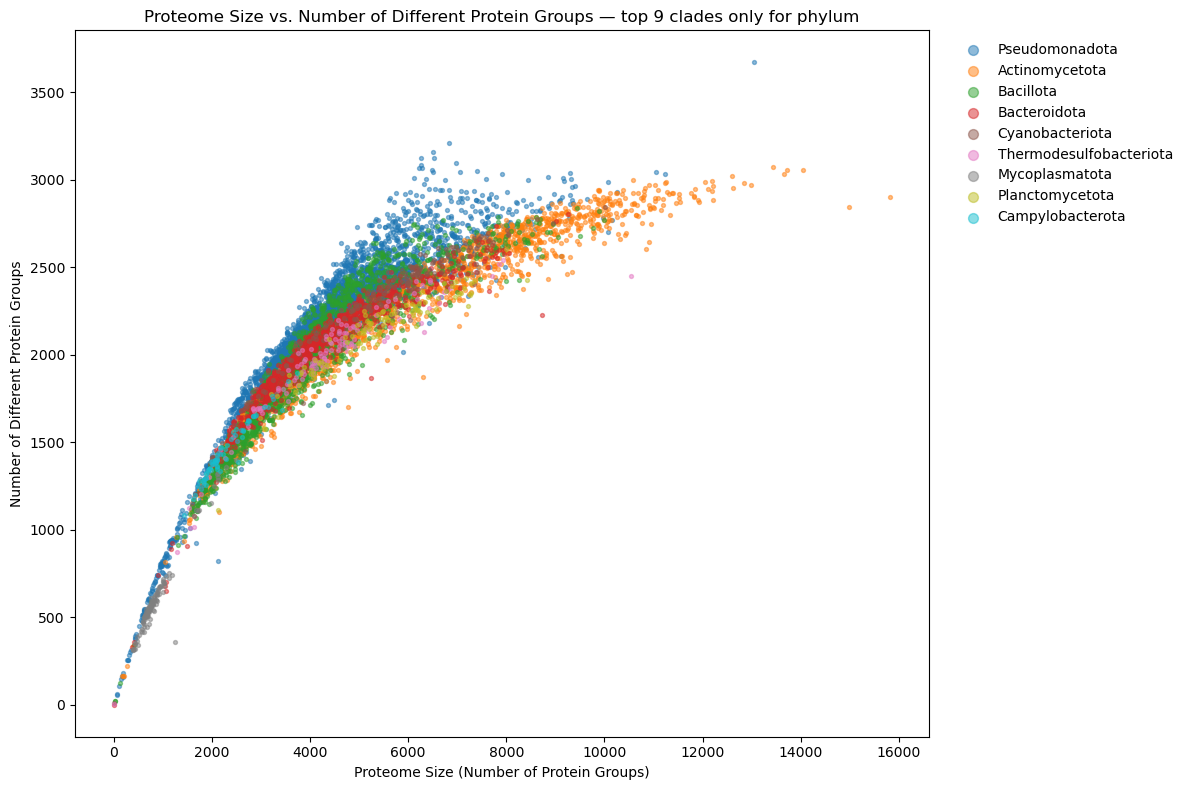

<Figure size 640x480 with 0 Axes>

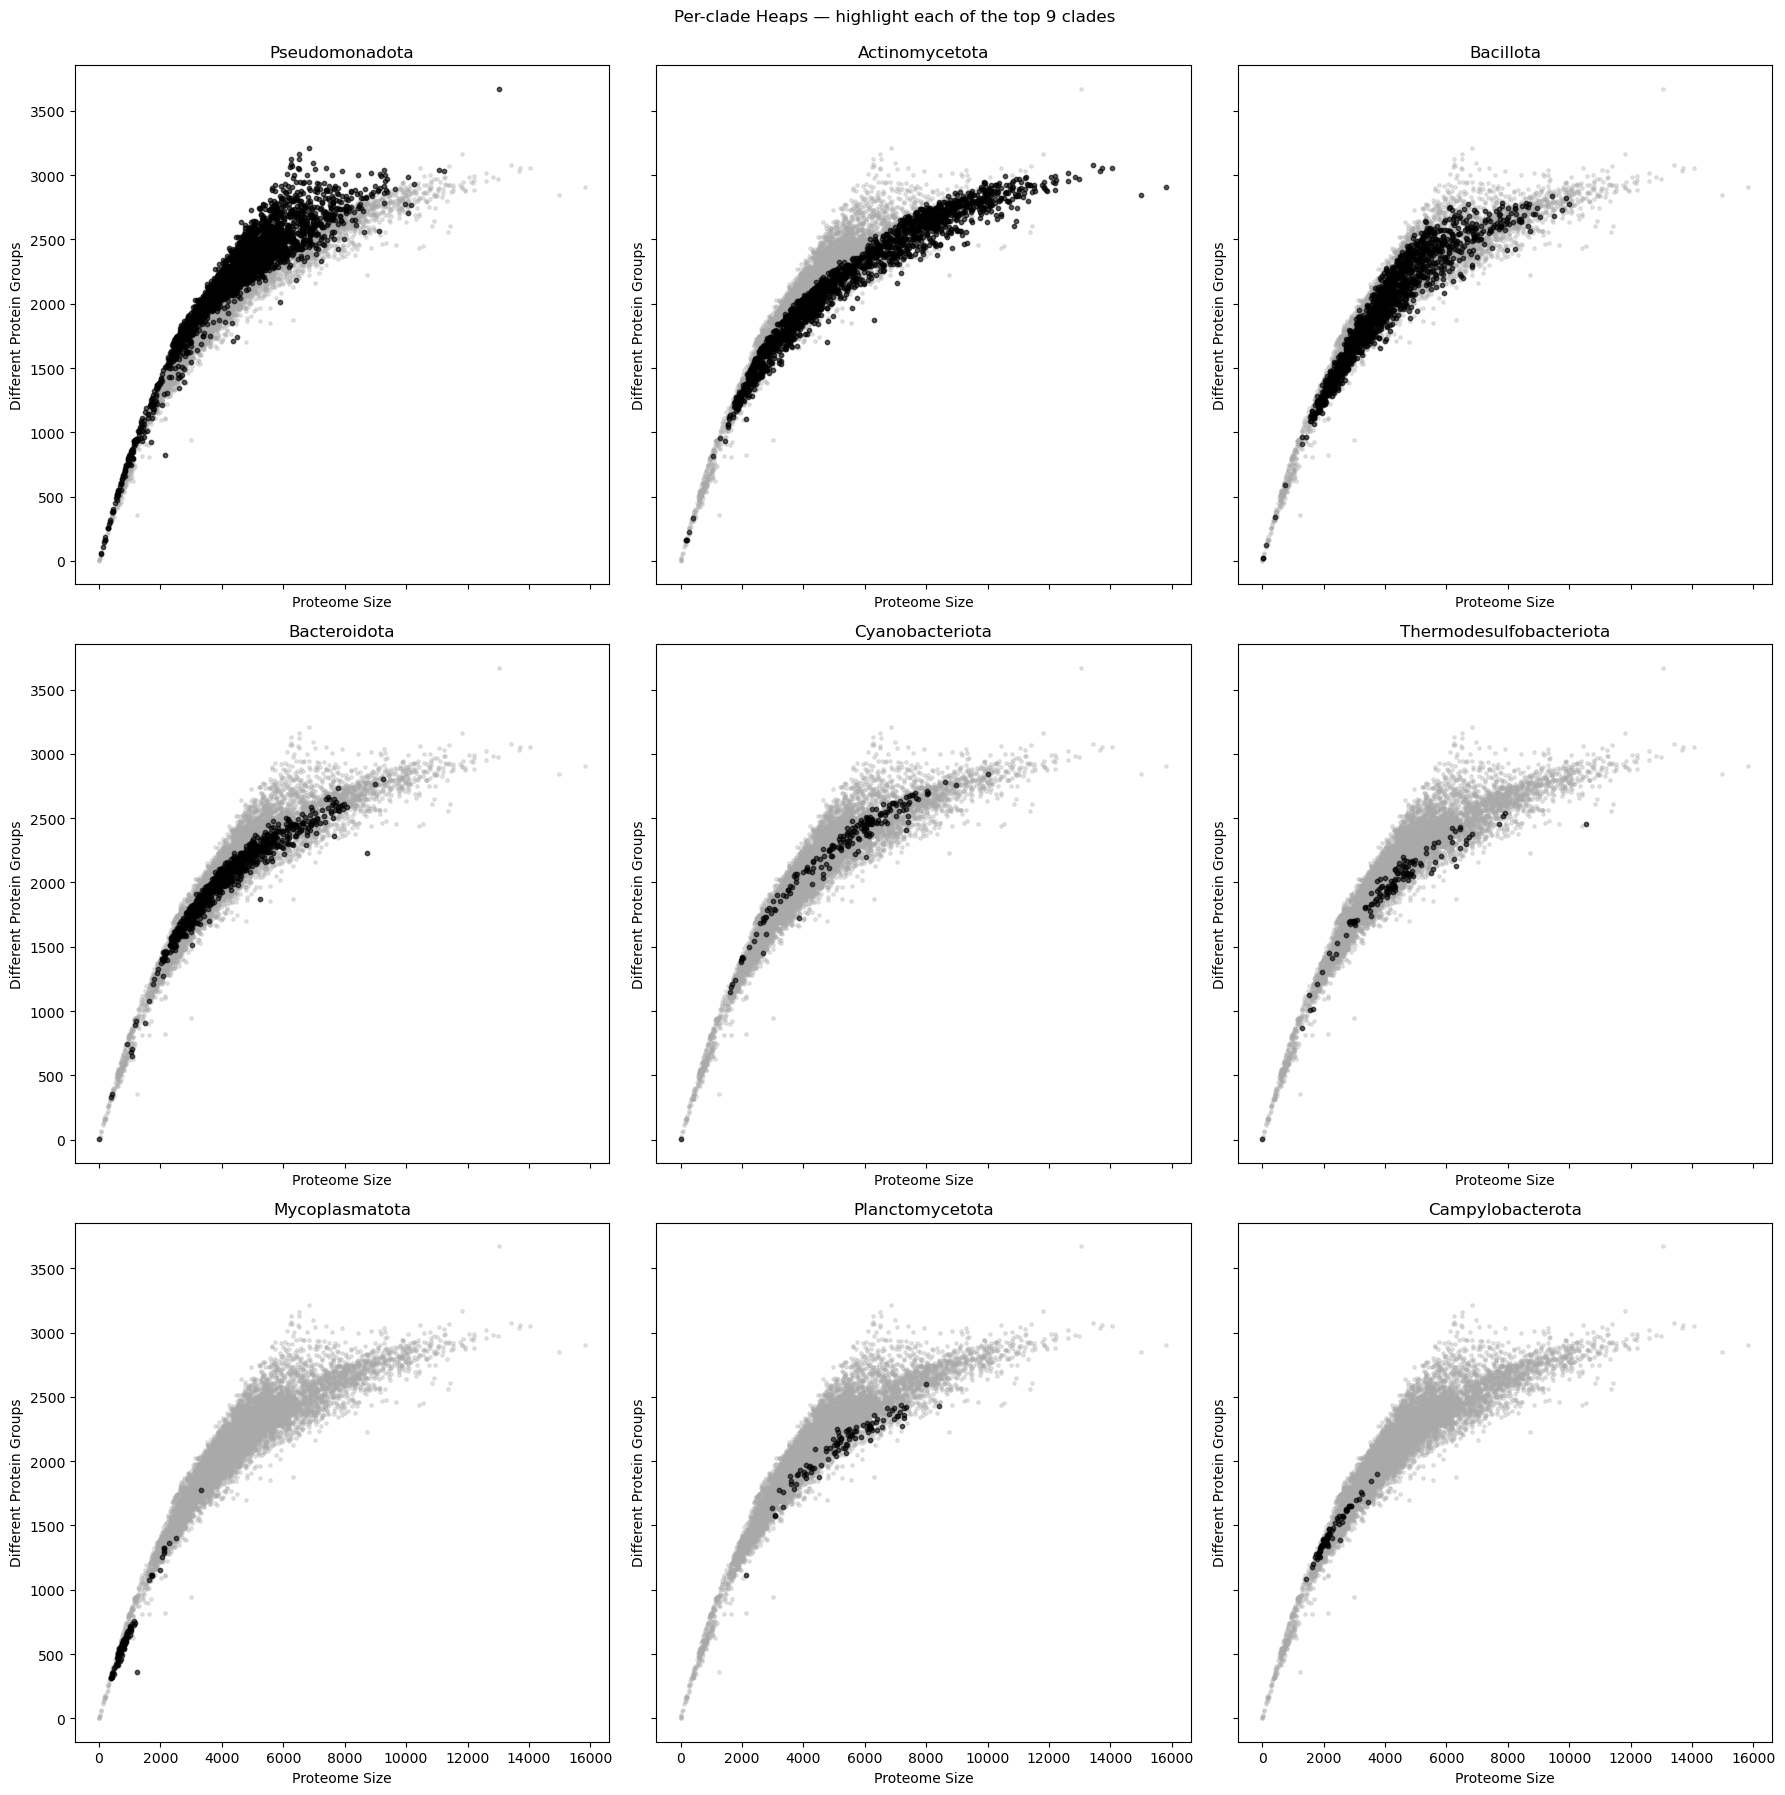

<Figure size 640x480 with 0 Axes>

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

# --- Heaps' coordinates ---
proteome_sizes = count_matrix.sum(axis=1)
n_different_families = (count_matrix > 0).sum(axis=1)

df = pd.DataFrame({
    'size': proteome_sizes,
    'richness': n_different_families,
    'clade': clade_series
}).dropna()

# --- pick top-K clades by sample count ---
K = 9
top_clades = df['clade'].value_counts().head(K).index.tolist()

# consistent color map for the top K (keep order by frequency)
cmap = plt.get_cmap('tab10', len(top_clades))
clade_color = {cl: cmap(i) for i, cl in enumerate(top_clades)}

# 1) COMBINED PLOT: only top-K clades (no "Other")
df_top = df[df['clade'].isin(top_clades)].copy()

plt.figure(figsize=(12, 8))
# optional 1:1 guide
# x = np.linspace(0, df['size'].max()*1.05, 200)
# plt.plot(x, x, linestyle='--', color='grey', linewidth=1, alpha=0.6)

for cl in top_clades:
    sub = df_top[df_top['clade'] == cl]
    plt.scatter(sub['size'], sub['richness'], s=8, alpha=0.5, label=cl, c=[clade_color[cl]])

plt.xlabel('Proteome Size (Number of Protein Groups)')
plt.ylabel('Number of Different Protein Groups')
plt.title(f'Proteome Size vs. Number of Different Protein Groups — top {K} clades only for {TARGET_RANK}')
plt.legend(markerscale=2.5, frameon=False, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()
#savefig as svg
plt.savefig(f'../pictures/heaps_top{K}_{TARGET_RANK}.svg', format='svg')

# 2) FACETED PLOTS: one Heaps per clade; target clade colored, all others grey
# layout: up to 3 columns
cols = min(K, 3)
rows = ceil(K / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows), sharex=True, sharey=True)
axes = np.atleast_1d(axes).ravel()

# Precompute the grey background once
bg_x = df['size'].to_numpy()
bg_y = df['richness'].to_numpy()

for i, cl in enumerate(top_clades):
    ax = axes[i]
    # background: everyone grey (including non-top-K)
    ax.scatter(bg_x, bg_y, s=6, alpha=0.3, color='darkgrey')

    # highlight the clade in color
    sub = df[df['clade'] == cl]
    ax.scatter(sub['size'], sub['richness'], s=10, alpha=0.6, c='black', label=cl)

    # optional 1:1 guide
    # x = np.linspace(0, df['size'].max()*1.05, 200)
    # ax.plot(x, x, linestyle='--', color='grey', linewidth=1, alpha=0.6)

    ax.set_title(cl)
    ax.set_xlabel('Proteome Size')
    ax.set_ylabel('Different Protein Groups')
    #ax.legend(frameon=False, loc='lower right')

# hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(f'Per-clade Heaps — highlight each of the top {K} clades', y=0.995)
plt.tight_layout()
plt.show()
#savefig as svg
plt.savefig(f'../pictures/heaps_facet_top{K}_{TARGET_RANK}.svg', format='svg')